In [31]:
# We shall download landsat scenes from USGS Earth Explorer

from landsatxplore.api import API
from landsatxplore.earthexplorer import EarthExplorer

# Credentials
username = 'murucomus'
password = 'Welcome_123456'

# Initialize API and EarthExplorer instances
api = API(username, password)

import math

def calculate_bounding_box(latitude, longitude, radius):
    # Earth radius
    R = 6371.0
    
    # Convert radius to angular distance in radians
    
    rad_dist = radius / R
    
    #Cordinates for bounded box (bbox)

    # Convert latitude and longitude from degrees to radians
    lat = math.radians(latitude)
    lon = math.radians(longitude)

    # Calculate bounding box
    min_lat = lat - rad_dist
    max_lat = lat + rad_dist
    min_lon = lon - rad_dist / math.cos(lat)
    max_lon = lon + rad_dist / math.cos(lat)

    # Convert back to degrees
    min_lat, max_lat, min_lon, max_lon = map(math.degrees, [min_lat, max_lat, min_lon, max_lon])

    return (min_lon, min_lat, max_lon, max_lat)

latitude=0.3117  # Lat for Kampala City- nakivubo
longitude=32.5737 # Long for Kampala City Nakivubo
radius = 10  # Radius in kilometers 
# Create a bounding box within a specific radius from Kampala city
bbox = calculate_bounding_box(latitude, longitude, radius)
print(f"The cordinates for the bounded Box are: {bbox}")

# Search for Landsat TM scenes
scenes = api.search(
    dataset='LANDSAT_OT_C2_L2',
    # latitude=0.3152  # Lat for Kampala City
    # longitude=32.5816 # Long for Kampala City
    ###bbox= bbox, #Bounding box with radius of 50kms
    start_date='2019-07-31',
    end_date='2019-07-31',
    max_cloud_cover=10
)

print(f"{len(scenes)} scenes found.")


# Initialize EarthExplorer
ee = EarthExplorer(username, password)

import random

import os
import shutil

def overwrite_directory(directory_path):
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)   
    os.makedirs(directory_path) # Create the new directory

    # Define the directory path
directory_path = "landsat_dat"
overwrite_directory(directory_path)

# Download a randomly selected scene from the list of scenes
if scenes:
    random_scene=random.choice(scenes)
    scene_id = random_scene['display_id']
    print(f"The scene ID is {scene_id}")
    #try:
        # Download the randomised scene dataset
    ee.download(scene_id, output_dir=directory_path)
    
    
    #except TimeoutError as e:
       # print(f"Operation time out: {e}")
    #except ConnectionError as e:
        #print(f"Network connection error: {e}")
    #except Exception as e:
        #print(f"An unexpected error occurred while downloading {scene_id}: {e}")

    print(f"Downloaded {scene_id}")
  
# Logout of Earth Explorer API

api.logout()
ee.logout()



The cordinates for the bounded Box are: (32.483766508589945, 0.22176783940812694, 32.66363349141006, 0.40163216059187307)
100 scenes found.
The scene ID is LC08_L2SR_059063_20190731_20201016_02_T1
Download failed with dataset id 1 of 3. Re-trying with the next one.


100%|███████████████████████████████████████████████████████████████████████████████| 562M/562M [01:04<00:00, 9.21MB/s]


None of the archived ids succeeded! Update necessary!


EarthExplorerError: 

In [32]:
#Processing the downloaded scene file (.tar file)

import tarfile

#Path to the landsat dataset .tar file
file_directory= "landsat_dat/"
file_extension= ".tar"
full_file_path= file_directory+scene_id+file_extension

tar_file_path= full_file_path

print(tar_file_path) #confirmation of the file path for the downloaded file

#Extract the .tar file
extracted_dir= "landsat_dat/extracted_files" #Directory to extract the .tar files into
os.makedirs(extracted_dir, exist_ok=True)

with tarfile.open(tar_file_path, "r") as file:
    file.extractall(extracted_dir)

#Filter extracted files using specific keywords

all_files=os.listdir(extracted_dir) #List of all files within the extracted directory  

print(f"There are {len(all_files)} files") #print a list of files to confirm the files within the directory

#Define keywords for filtering
keywords= ['B2.TIF', 'B3.TIF', 'B4.TIF', 'B5.TIF', 'B7.TIF']

#Filter the list of files by keyword (spectral bands R, G, B, SWIR, etc)
filtered_files = [file for file in all_files if any(keyword in file for keyword in keywords)]

if filtered_files:
    print(f" The filtered files are: {filtered_files}")
else:
    print("No files were filtered")

#We now open the files based on the applied filter

import rasterio
#Opening the red, green and blue bands
if len(filtered_files) >= 5:
    file_to_open = [os.path.join(extracted_dir, f) for f in filtered_files[:5]]

    with rasterio.open(file_to_open[0]) as green, \
         rasterio.open(file_to_open[1]) as blue, \
         rasterio.open(file_to_open[2]) as red, \
         rasterio.open(file_to_open[3]) as nir, \
         rasterio.open(file_to_open[4]) as swir:
        # Read each band
        green_band = green.read(1)
        blue_band = blue.read(1)
        red_band = red.read(1)
        nir_band = nir.read(1)
        swir_band = swir.read(1)     

else:
    print("Not enough files to proceed with band opening")

landsat_dat/LC08_L2SR_059063_20190731_20201016_02_T1.tar
There are 17 files
 The filtered files are: ['LC08_L2SR_059063_20190731_20201016_02_T1_SR_B2.TIF', 'LC08_L2SR_059063_20190731_20201016_02_T1_SR_B3.TIF', 'LC08_L2SR_059063_20190731_20201016_02_T1_SR_B4.TIF', 'LC08_L2SR_059063_20190731_20201016_02_T1_SR_B5.TIF', 'LC08_L2SR_059063_20190731_20201016_02_T1_SR_B7.TIF']


float64
nan nan


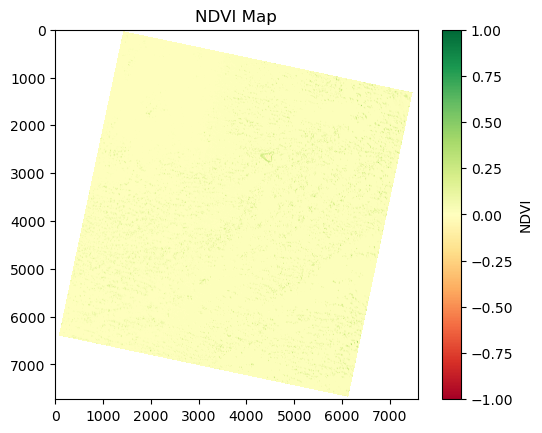

(0.0, 1.0, 0.0, 1.0)

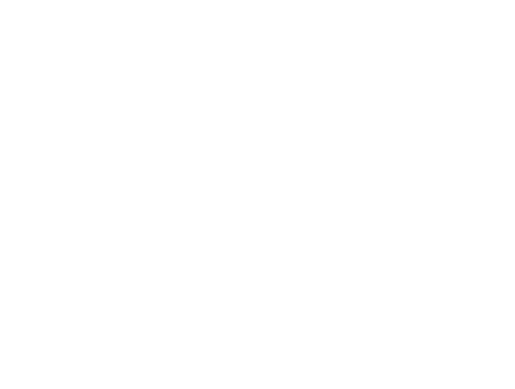

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import io
from PIL import Image

# Create a true-color composite by stacking the RGB bands
true_color= np.dstack((red_band, green_band, blue_band))

#Display the image

#plt.imshow(true_color)
#plt.title('Landsat 8 True Color Composite')
#plt.axis('off') #Hide axis labels
#plt.show()

from skimage import exposure

#Adjust contrast
#true_color_enhanced= exposure.equalize_hist(true_color)
#plt.imshow(true_color_enhanced)
#plt.title('Enhanced True Color landsat Composite image')
#plt.axis('off')
#plt.show()

#Convert to float for division
nir_band=nir_band.astype(float)
red_band= red_band.astype(float)

#Avoid division by zero
np.seterr(divide='ignore', invalid='ignore')

#calculate NDVI
ndvi= (nir_band-red_band)/(nir_band+red_band)

print(ndvi.dtype)
print(np.min(ndvi), np.max(ndvi))

###########################################

#Visualise Normalised Difference Vegetation Index (NDVI)

plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.title('NDVI Map')
plt.show()
plt.axis('off')

In [34]:
#Create interactive map using folium

import folium
#Create a map centered around Kampala city
m=folium.Map(location=[latitude,longitude], zoom_start=12)

#Display the map
#m


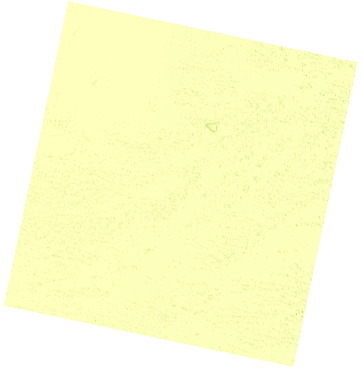

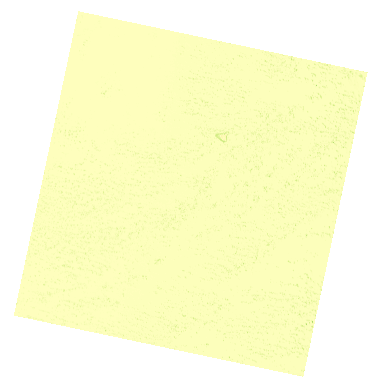

In [35]:
#We want to overlay the NDVI colormap to the map of Uganda
import base64

# Create a colormap for NDVI with ability for contrast adjustment
#ndvi_adjusted= np.clip(ndvi, a_min=-0.1, a_max=0.3)  ##Clip NDVI values to enhance contrast in a specific range

#plt.imshow(ndvi_adjusted, cmap='RdYlGn')

#Same NDVI colormap without adjustment
plt.imshow(ndvi, cmap='RdYlGn')
#plt.colorbar()
plt.axis('off')

# Adjust layout to reduce white space
#plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

#Save the NDVI image to a buffer
buf= io.BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)  ##tight
buf.seek(0)

#Create a PIL image object
ndvi_image=Image.open(buf)
#Convert the PIL image to a base64 encoded string
encoded = base64.b64encode(buf.getvalue()).decode('UTF-8')

# Add NDVI colormap overlay to the map of Uganda

#Use the calculate_bounding_box(latitude, longitude, radius) function to get the bounds
#(min_lon, min_lat, max_lon, max_lat)
min_longitude, min_latitude, max_longitude, max_latitude= calculate_bounding_box(latitude, longitude, radius)

folium.raster_layers.ImageOverlay(
    image='data:image/png;base64,'+encoded,
    bounds= [[min_latitude,min_longitude], [max_latitude, max_longitude]],  # replace with the bounds of your NDVI data
    opacity=0.8,  # Adjust as needed
    interactive= True
).add_to(m)

folium.Marker([latitude, longitude], 
              popup='Nakivubo'
             ).add_to(m) #Add a popup marker

# Display the map
m


In [36]:
folium.LayerControl().add_to(m)
m.save('m.html')

In [9]:
from html2image import Html2Image

hti = Html2Image()

# Paths to your HTML files
html_file_paths = ['2017 landsat ndvi.html', '2018 landsat ndvi.html', '2019 landsat ndvi.html',
                   '2020 landsat ndvi.html', '2021 landsat ndvi.html', '2022 landsat ndvi.html']

# Corresponding output PNG file paths
output_png_paths = ['2017 landsat ndvi.png', '2018 landsat ndvi.png', '2019 landsat ndvi.png',
                    '2020 landsat ndvi.png', '2021 landsat ndvi.png', '2022 landsat ndvi.png']

# Loop through each HTML file and convert it to an image
for html_file_path, output_png_path in zip(html_file_paths, output_png_paths):
    # Read the HTML file
    with open(html_file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()

    # Convert HTML to Image
    hti.screenshot(html_str=html_content, save_as=output_png_path)



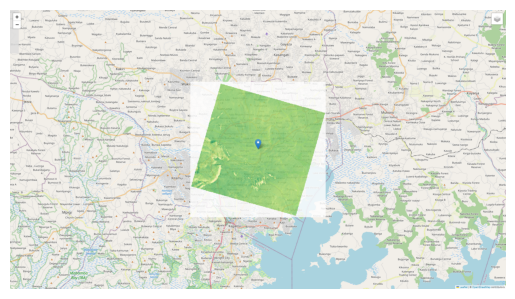

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
for 
img = mpimg.imread('./2017 landsat ndvi.png')

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()


In [113]:
import glob
import cv2
import numpy as np
file= '*.png'
glob.glob(file)

['Kampala_City_2017 landsat ndvi.png',
 'Kampala_City_2018 landsat ndvi.png',
 'Kampala_City_2019 landsat ndvi.png',
 'Kampala_City_2020 landsat ndvi.png',
 'Kampala_City_2021 landsat ndvi.png',
 'Kampala_City_2022 landsat ndvi.png',
 'Time_Series_Analysis for NDVI for Kampala City.png']

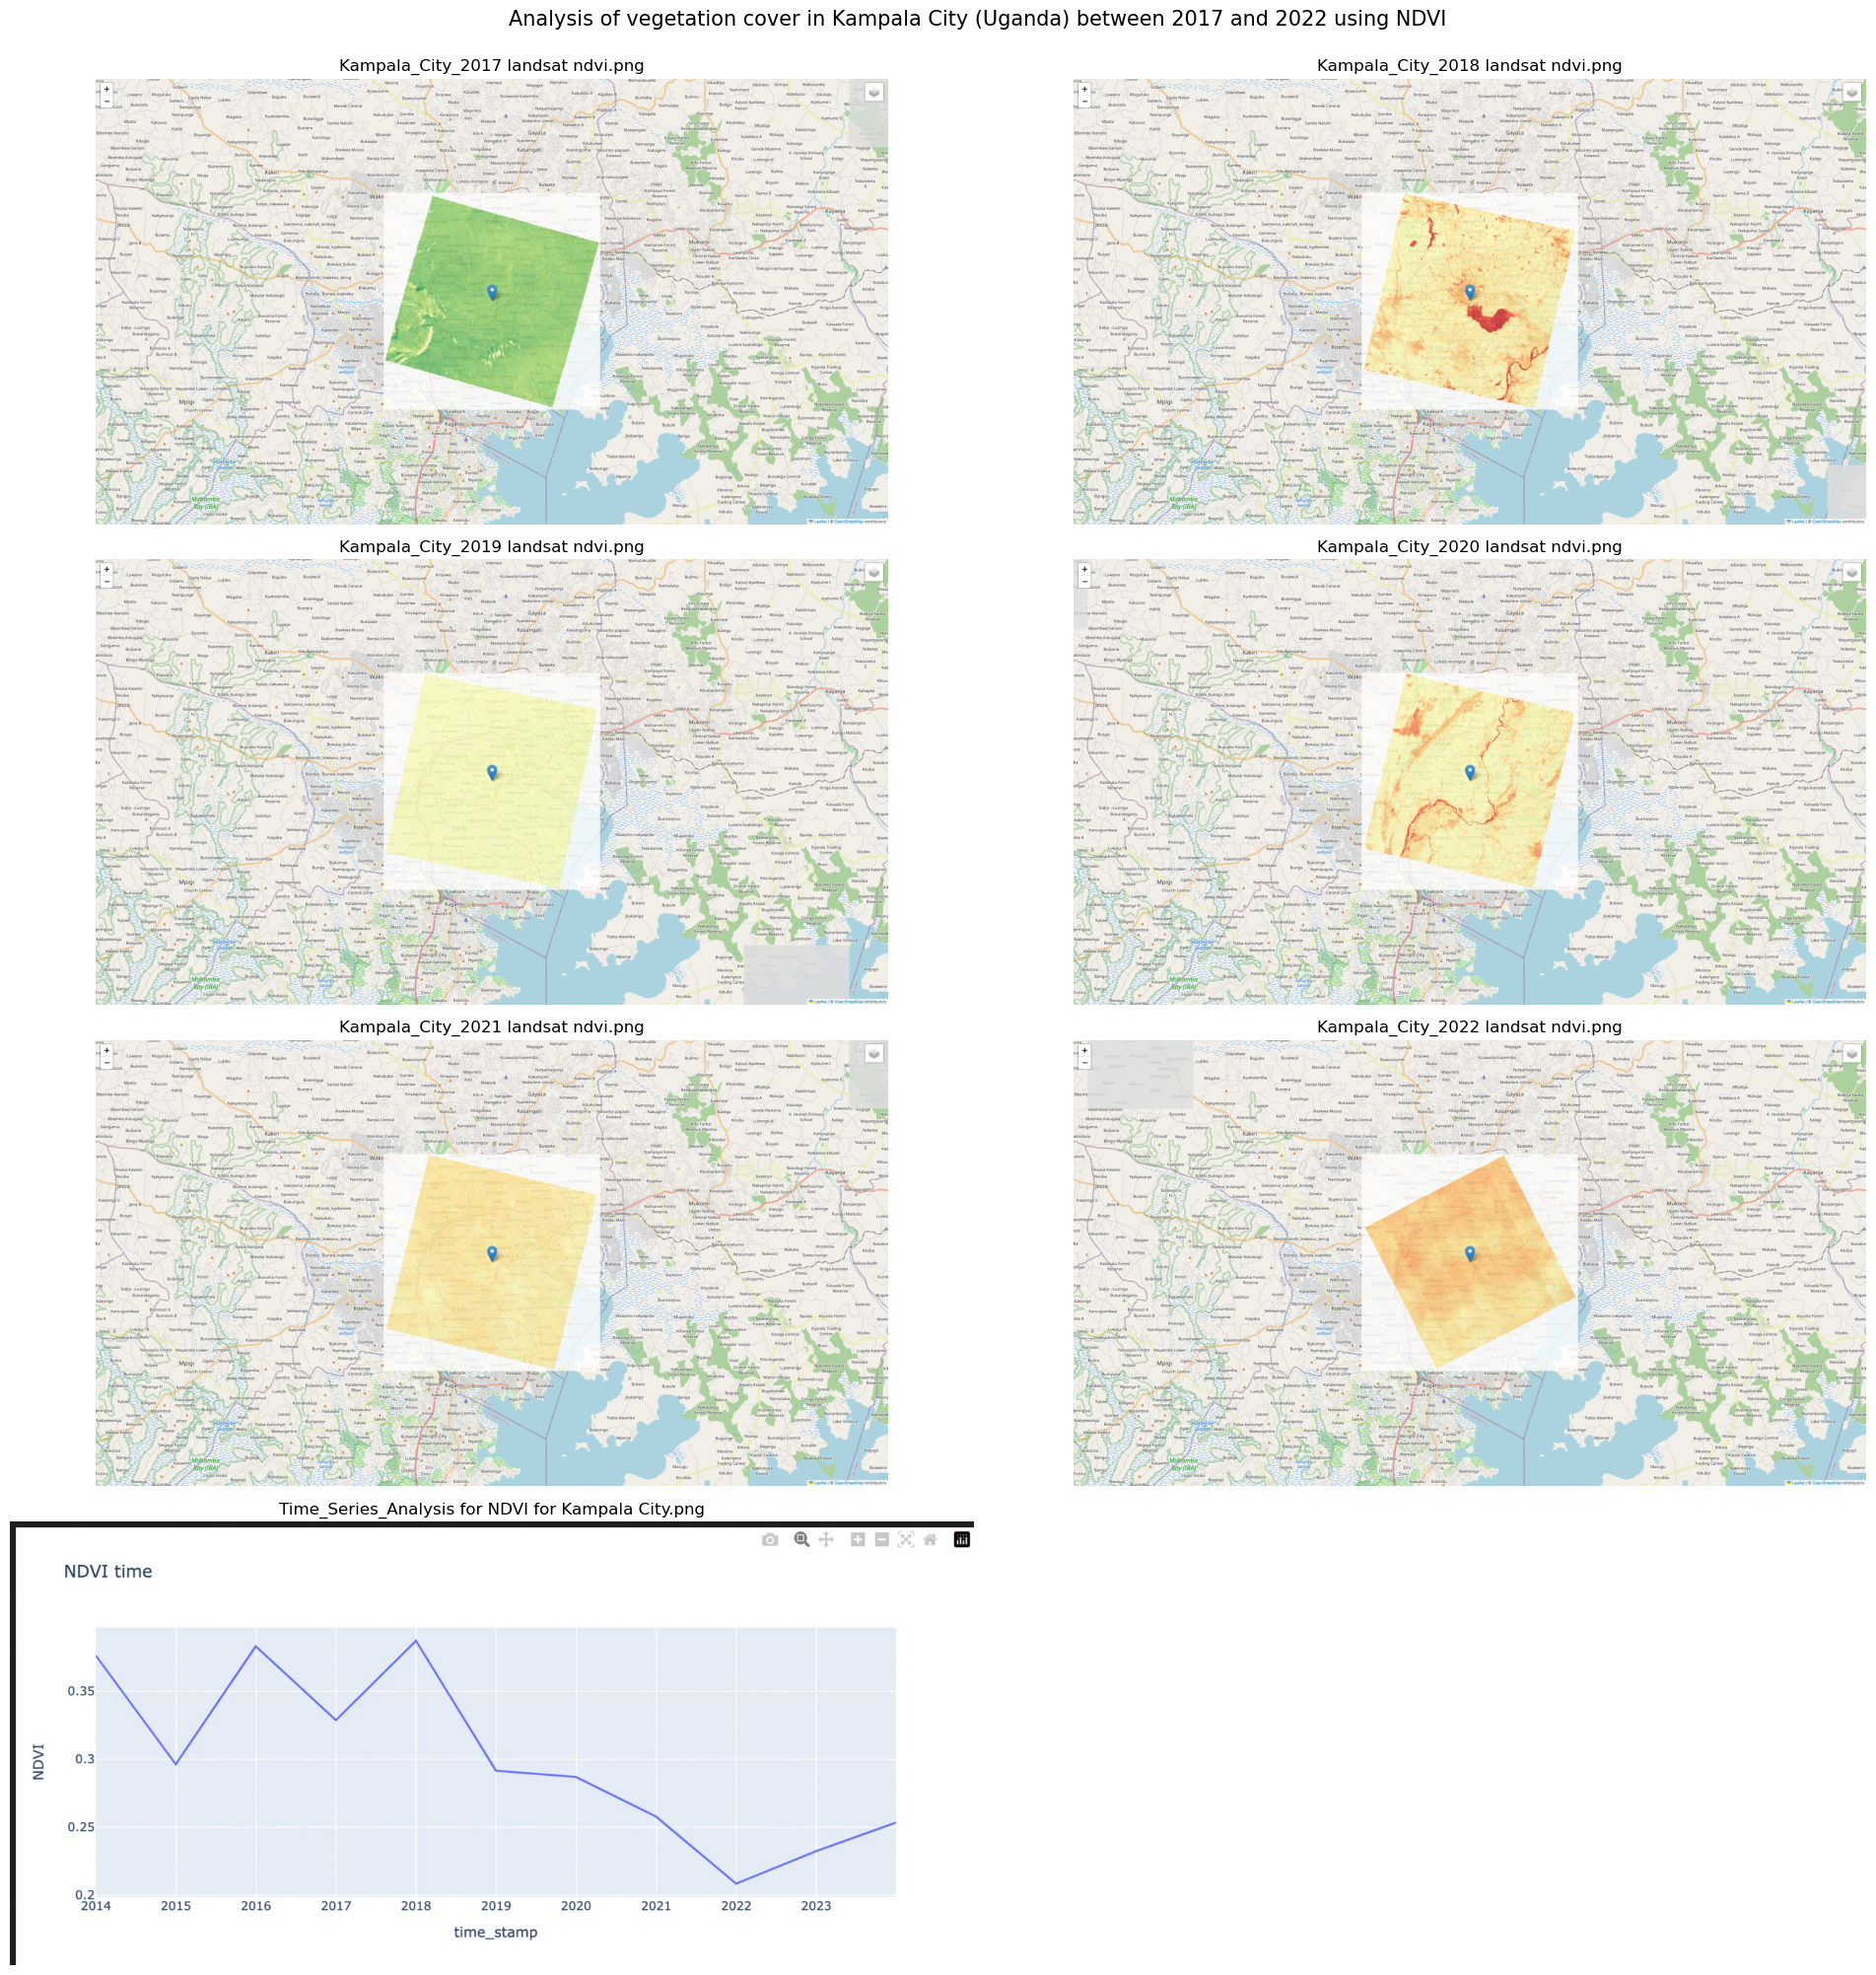

In [134]:
images=[cv2.imread(image) for image in glob.glob(file)]
image_paths= glob.glob(file)
type(images)
len(images)
rows=4
cols=2

for i in range(0, len(images), rows*cols):
    fig = plt.figure(figsize=(20,20))
    for j in range(0, rows*cols):
        # Check if the index exists in the images list
        if i + j < len(images):
            img = images[i + j]
            ax = fig.add_subplot(rows, cols, j + 1)
        #fig.add_subplot(rows, cols, j+1)
        #plt.imshow(images[i+j])
    #plt.show()
        # Convert from BGR to RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Display the image
            ax.imshow(img_rgb)
            ax.axis('off')  # Hide the axis

            # Set the title (label) for each image
            # Here we use the filename as the label. Modify as needed.
            image_label = os.path.basename(image_paths[i + j])
            ax.set_title(image_label)
            fig.suptitle('Analysis of vegetation cover in Kampala City (Uganda) between 2017 and 2022 using NDVI ', fontsize=15, y=1)


    # Display the figure with all subplots
plt.tight_layout()   
#plt.tight_layout(pad=1.0, h_pad=1, w_pad=1)

plt.show()

In [135]:
# Save the figure with all subplots as an image file
fig.savefig(f'output_{i}.png')  # Saves each grid as a separate file

plt.close(fig)  # Close the figure to free up memory